# Install Requirements

In [1]:
%pip install transformers datasets
%pip install torch
%pip install matplotlib
%pip install umap-learn numba==0.48.0
%pip install pandas matplotlib datashader bokeh holoviews colorcet scikit-image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached numba-0.48.0.tar.gz (2.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached llvmlite-0.31.0.tar.gz (110 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.2.tar.gz (86 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.1.tar.gz (80 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.0.tar.gz (81 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap_learn-0.4.6-py3-none-any.whl
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [755 lines of output]
      /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-install-u0skas7t/numba_c6e5efcbfe5541ddbb963a396f56e860/setup.py:98: DeprecationWarning:
      
        `

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Language Model

In [3]:
#MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled" # NL MODEL TODO: is the model trained on lowercased data?

MODEL_NAME = "roberta-base"

#MODEL_NAME = "xlm-roberta-base" # cross-lingual mode (https://huggingface.co/xlm-roberta-base)


In [4]:
from transformers import RobertaModel, AutoTokenizer, RobertaPreTrainedModel, BertModel, GPT2Model, pipeline
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
#model = RobertaModel.from_pretrained(MODEL_NAME)

# FIXME: cannot use pipeline for extracting layers other than the last one
model: FeatureExtractionPipeline = pipeline('feature-extraction', model=MODEL_NAME, tokenizer=tokenizer)

/Users/carstenschnober/opt/anaconda3/envs/SoS/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Load Data

In [5]:
from pathlib import Path

DATA_DIR = Path.cwd() / "data"

## SemEval 2020 (C)COHA corpus

### Download

In [6]:
from io import BytesIO
from zipfile import ZipFile
import urllib

SEMEVAL_DATA_URL = "https://www2.ims.uni-stuttgart.de/data/sem-eval-ulscd/semeval2020_ulscd_eng.zip"

SEMEVAL2020_DIR = DATA_DIR / "semeval2020_ulscd_eng"

if SEMEVAL2020_DIR.is_dir():
    print(f"Directory '{SEMEVAL2020_DIR}' already exists, skipping corpus download.")
else:
    with urllib.request.urlopen(SEMEVAL_DATA_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(DATA_DIR)

assert SEMEVAL2020_DIR.is_dir(), f"Directory does not exist: '{SEMEVAL2020_DIR}'"


Directory '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/semeval2020_ulscd_eng' already exists, skipping corpus download.


In [7]:
CORPUS1_DIR = SEMEVAL2020_DIR / 'corpus1'
CORPUS2_DIR = SEMEVAL2020_DIR / 'corpus2'
TRUTH_DIR = SEMEVAL2020_DIR / 'truth'

assert CORPUS1_DIR.is_dir(), f"Directory does not exist: '{CORPUS1_DIR}'"
assert CORPUS2_DIR.is_dir(), f"Directory does not exist: '{CORPUS2_DIR}'"
assert TRUTH_DIR.is_dir(), f"Directory does not exist: '{TRUTH_DIR}'"


### Read

In [8]:
TOKENS_FILE1 = CORPUS1_DIR / "token" / "ccoha1.txt.gz"
TOKENS_FILE2 = CORPUS2_DIR / "token" / "ccoha2.txt.gz"

assert TOKENS_FILE1.is_file()
assert TOKENS_FILE2.is_file()

In [9]:
import gzip

with gzip.open(TOKENS_FILE1, 'rt') as f:
    sentences_1810 = f.readlines()

assert len(sentences_1810) == 253644

with gzip.open(TOKENS_FILE2, 'rt') as f:
    sentences_1960 = f.readlines()

assert len(sentences_1960) == 353692

## COHA Corpus (Sample)

### Download

In [10]:
#COHA_DATABASE_URL = 'https://www.corpusdata.org/coha/samples/database.zip'
COHA_TEXT_URL = 'https://www.corpusdata.org/coha/samples/text.zip'

COHA_DIR = DATA_DIR / "COHA"

try:
    COHA_DIR.mkdir(parents=True, exist_ok=False)
except OSError as e:
    print(f"Directory '{COHA_DIR}' already exists: {str(e)}. Skipping corpus download.")
else:
    with urllib.request.urlopen(COHA_TEXT_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(COHA_DIR)

assert COHA_DIR.is_dir()

Directory '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/COHA' already exists: [Errno 17] File exists: '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/COHA'. Skipping corpus download.


### Read

In [56]:
from functools import cached_property
import logging
import re
from typing import Generator, List

FILENAME_PATTERN = r"([a-z]{2,4})_(\d{4})_(\d{3,6})\.txt"
SENTENCE_PATTERN = r"\s*(.*?\s[\.!?\n])"

class CohaDoc:
    _encoding = 'UTF-8'

    def __init__(self, path: Path):
        self._path = path

        try:
            genre, year, id = re.search(FILENAME_PATTERN, self._path.name).groups()
        except AttributeError as e:
            raise ValueError(f"Could not parse path: '{path}': {str(e)}")
        
        self._genre = genre
        self._year = int(year)
        self._id = int(id)

    def __repr__(self) -> str:
        return str(self._path.name)

    def __str__(self) -> str:
        return str(self._path.name)

    @property
    def genre(self) -> str:
        return self._genre

    @property
    def year(self) -> int:
        return self._year

    @property
    def id(self) -> int:
        return self._id
    
    @cached_property
    def text(self):
        with open(self._path, 'rt', encoding=self._encoding) as f:
            return f.read()

    def sentences(self):
        sentences = re.findall(SENTENCE_PATTERN, self.text)
        assert sentences[0].strip() == f"@@{self._id}", f"First line is expected to match document ID ('{self._id}'), but is: {sentences[0]}"
        return sentences[1:]

    def find_sentences(self, term: str) -> List[str]:
        return [
            sentence
            for sentence in self.sentences()
            if term in sentence
        ]
        
    def clean_sentences(self):
        # TODO
        return NotImplemented


In [12]:
coha_docs = [CohaDoc(file) for file in COHA_DIR.glob('*.txt')]

assert len(coha_docs) == 1144

(array([ 12.,  13.,  24.,  50.,  60., 156., 206., 188., 247., 188.]),
 array([1817. , 1836.2, 1855.4, 1874.6, 1893.8, 1913. , 1932.2, 1951.4,
        1970.6, 1989.8, 2009. ]),
 <BarContainer object of 10 artists>)

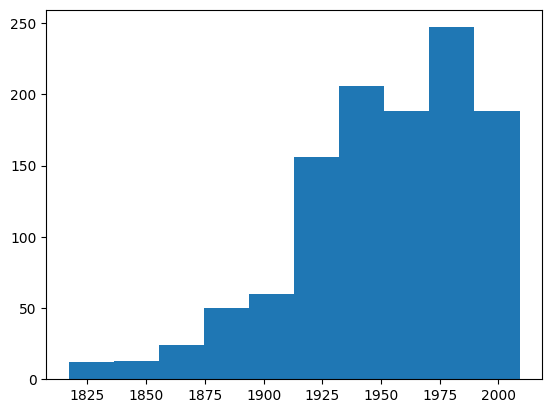

In [13]:
plt.hist([c.year for c in coha_docs])

(array([586.,   0.,   0., 424.,   0.,   0., 108.,   0.,   0.,  26.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

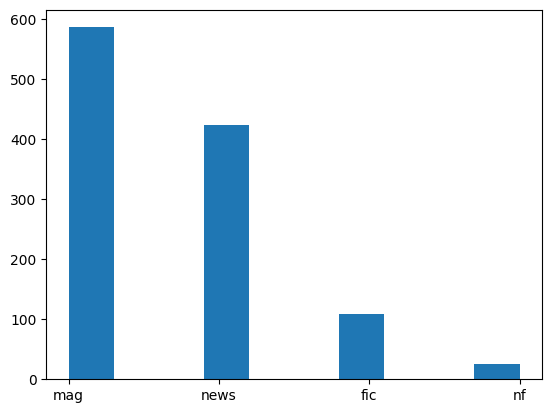

In [14]:
plt.hist([c.genre for c in coha_docs])

# Embeddings

## COHA

In [34]:
TERM1 = 'New York'
TERM2 = 'Philadelphia'

In [35]:

from tqdm import tqdm


for doc in tqdm(coha_docs, unit='doc'):
    if matches := doc.find_sentences(TERM1):
        print(doc)


  4%|▍         | 44/1144 [00:00<00:05, 219.18doc/s]

news_1953_715250.txt
fic_1979_10650.txt
fic_1999_44350.txt
mag_1935_154650.txt
fic_1946_781950.txt
news_1909_781450.txt
news_1948_711050.txt
mag_1976_290750.txt
news_2006_636150.txt
news_1983_669250.txt
news_1979_734350.txt
news_1969_727550.txt
fic_2004_29450.txt
mag_1981_494150.txt
mag_1995_426450.txt
mag_1936_141050.txt
mag_1954_129850.txt
nf_1922_773550.txt
fic_1836_7350.txt
news_1937_702450.txt
mag_1978_288850.txt
mag_1962_269050.txt
mag_2007_389750.txt
news_1962_722350.txt
news_1969_727750.txt
mag_1935_469650.txt
fic_2006_27950.txt
mag_1909_437650.txt
mag_1961_270650.txt


 14%|█▍        | 165/1144 [00:00<00:02, 421.36doc/s]

fic_1896_3350.txt
news_1916_682550.txt
news_1987_670150.txt
news_1920_684950.txt
mag_1945_159150.txt
news_1991_649950.txt
news_1944_708150.txt
nf_1999_775050.txt
fic_1941_780150.txt
mag_1988_337750.txt
news_1939_703750.txt
news_1976_732550.txt
mag_1925_467950.txt
news_1963_723350.txt
mag_1999_407150.txt
mag_1916_486250.txt
nf_1999_774950.txt
news_1934_700850.txt
mag_1827_553850.txt
nf_2006_776550.txt
mag_1983_494450.txt
mag_1841_554950.txt
mag_1882_577950.txt
mag_1860_556850.txt
news_1920_685450.txt
mag_1967_490650.txt
mag_1914_435950.txt
news_1949_711950.txt
news_1873_741150.txt
mag_2006_384550.txt
news_1988_670650.txt
news_1961_721650.txt
mag_2007_390950.txt
mag_1951_476350.txt
mag_1902_430050.txt
mag_1928_301050.txt
news_1984_670950.txt
news_1946_709950.txt
mag_1982_293650.txt
news_1932_698750.txt


 31%|███       | 355/1144 [00:00<00:01, 692.87doc/s]

mag_1843_555150.txt
mag_1928_299750.txt
fic_1999_44750.txt
news_1911_679350.txt
fic_1868_9550.txt
mag_1924_253750.txt
mag_1928_300950.txt
mag_1990_419850.txt
mag_1974_487950.txt
news_1995_638650.txt
mag_2007_391050.txt
news_1995_614450.txt
news_1986_669550.txt
mag_1958_61050.txt
mag_1994_399550.txt
news_1886_745650.txt
news_1937_702750.txt
mag_1999_403150.txt
mag_1981_432050.txt
news_1978_733550.txt
mag_1962_268850.txt
news_1909_678450.txt
mag_1945_159050.txt
mag_1988_337250.txt
mag_1928_163150.txt
mag_1961_270750.txt
news_1945_709050.txt
mag_1998_400150.txt
fic_2000_30250.txt
fic_1981_780050.txt
mag_1939_470250.txt
news_1983_669350.txt
news_1900_675450.txt
mag_1946_160150.txt
mag_1945_159250.txt
news_2005_607650.txt
mag_1994_393650.txt
news_1953_715350.txt
mag_1961_270550.txt
news_1963_723450.txt
mag_1964_270150.txt
news_1978_733750.txt
news_1983_671250.txt
mag_1930_490250.txt
mag_2002_423750.txt
news_1920_685350.txt
mag_1989_432450.txt
fic_1883_2450.txt
news_1946_709850.txt
news_1964

 46%|████▋     | 530/1144 [00:00<00:00, 732.60doc/s]

mag_1990_420450.txt
fic_1874_9050.txt
mag_1954_231350.txt
mag_1886_571250.txt
news_2007_641850.txt
mag_1977_291650.txt
news_1956_717750.txt
news_1999_664450.txt
fic_1972_10550.txt
mag_1928_163550.txt
news_1958_720050.txt
mag_1838_586150.txt
news_1926_692350.txt
mag_1950_492350.txt
mag_1987_335350.txt
news_1984_671350.txt
mag_1965_492050.txt
mag_1926_490150.txt
nf_1948_773450.txt
news_1898_674950.txt
news_1967_726750.txt
news_1957_718550.txt
fic_1920_550.txt
mag_1910_486950.txt
news_1951_713750.txt
mag_1991_421250.txt
mag_1992_423450.txt
mag_1970_494650.txt
mag_1877_559050.txt
news_1932_699150.txt
mag_1979_289550.txt
fic_1874_2650.txt
news_1910_678850.txt


 59%|█████▉    | 675/1144 [00:01<00:00, 673.85doc/s]

news_1947_710350.txt
news_1927_694350.txt
fic_1910_2750.txt
mag_1927_152050.txt
news_1940_704550.txt
news_1956_718450.txt
news_1956_717950.txt
news_1932_698850.txt
mag_1964_493850.txt
news_1897_674650.txt
news_1930_697450.txt
mag_1987_336050.txt
news_1950_713450.txt
mag_1928_164350.txt
news_1974_731450.txt
news_1939_704050.txt
mag_1994_426050.txt
fic_1942_13850.txt
nf_1991_774050.txt
fic_1919_1550.txt
news_1964_724350.txt
nf_1982_774150.txt
news_1996_625850.txt
mag_1863_500450.txt
news_1946_709450.txt
news_2007_643050.txt
mag_1943_157050.txt
news_1954_716550.txt
fic_1845_7450.txt
mag_1968_491550.txt
news_1984_669850.txt
mag_1934_469450.txt
news_1995_631350.txt
mag_1975_290450.txt
mag_2001_411050.txt
mag_1979_289350.txt
news_1931_698050.txt
mag_2006_383450.txt
mag_1926_468150.txt
mag_1916_493150.txt


 72%|███████▏  | 819/1144 [00:01<00:00, 677.77doc/s]

news_1997_611550.txt
nf_1842_747950.txt
mag_1937_154850.txt
news_1950_713050.txt
fic_1999_55350.txt
news_1930_697050.txt
news_2007_637850.txt
news_1936_701950.txt
mag_1944_157750.txt
mag_1837_554450.txt
news_1893_673150.txt
mag_1977_287950.txt
news_1956_718050.txt
news_1923_689350.txt
news_1930_697250.txt
mag_1904_486750.txt
mag_1985_480650.txt
mag_1987_336650.txt
news_1965_725150.txt
news_1983_668450.txt
news_1928_694650.txt
mag_1954_234550.txt
mag_1942_156650.txt
news_1952_715050.txt
news_1920_686050.txt
nf_1843_747650.txt
mag_1978_288550.txt
news_1938_703350.txt
fic_1956_10350.txt
nf_1940_774250.txt
mag_2004_413250.txt
mag_1924_448250.txt
mag_1957_431550.txt
news_1907_781050.txt
mag_1929_468550.txt
news_1968_726950.txt
mag_1929_301150.txt
news_1939_703950.txt
news_1936_702150.txt


 85%|████████▍ | 970/1144 [00:01<00:00, 703.11doc/s]

mag_1842_555050.txt
news_1929_696850.txt
fic_2009_36750.txt
mag_1876_560350.txt
mag_1976_287350.txt
mag_1923_254450.txt
mag_1913_487150.txt
news_1968_727050.txt
mag_1953_231950.txt
mag_1923_219750.txt
mag_1956_494550.txt
news_1964_724050.txt
news_1935_701050.txt
fic_1946_1050.txt
mag_1960_270350.txt
news_1910_679050.txt
news_1908_678050.txt
news_1918_683850.txt
news_1912_680050.txt
mag_1889_550050.txt
news_1938_703650.txt
mag_1928_299950.txt
news_1933_700350.txt
nf_2007_776450.txt
news_1897_674550.txt
news_1947_710250.txt
mag_1954_488250.txt
mag_1963_269550.txt
fic_1889_2950.txt
news_1939_704350.txt
mag_1947_305950.txt
mag_1928_164050.txt
mag_2005_418250.txt
mag_1977_288150.txt
mag_1859_567050.txt
news_1930_697350.txt
news_1993_600250.txt
mag_1899_592150.txt
news_1993_630350.txt
nf_1909_774350.txt
fic_2007_33750.txt
nf_1896_750650.txt
news_1956_718150.txt
news_1971_729650.txt


100%|██████████| 1144/1144 [00:01<00:00, 631.61doc/s]

nf_1918_773950.txt
mag_1976_290950.txt
news_1994_620050.txt
mag_1977_287850.txt
fic_1908_1150.txt
mag_1962_477950.txt
mag_1924_163350.txt
news_1941_705450.txt
mag_1855_505250.txt
mag_1957_132450.txt
news_1943_707350.txt
news_1935_701450.txt
news_2005_623950.txt
fic_2000_27350.txt
news_1946_709350.txt
news_1908_677950.txt
news_1938_703250.txt
mag_1921_493250.txt
fic_1877_9450.txt
news_1928_694750.txt
mag_2004_364750.txt
news_1986_670050.txt
mag_1942_156750.txt
fic_1915_5250.txt
mag_1991_421950.txt
mag_1954_234650.txt
news_1931_698150.txt
news_1937_702850.txt
mag_1981_490850.txt
news_1968_727450.txt
news_1985_671550.txt
news_1944_707650.txt
fic_1968_23850.txt
mag_1987_335850.txt
mag_1987_336550.txt
mag_1904_486450.txt
fic_1965_16750.txt
news_1930_697150.txt


# Embeddings

In [36]:
import collections
from dataclasses import dataclass
from functools import cache
from itertools import islice
from typing import Iterable, List, Optional, Tuple
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline

def sliding_window(iterable, n):
    # From https://docs.python.org/3/library/itertools.html#itertools-recipes
    # sliding_window('ABCDEFG', 4) --> ABCD BCDE CDEF DEFG
    it = iter(iterable)
    window = collections.deque(islice(it, n), maxlen=n)
    if len(window) == n:
        yield tuple(window)
    for x in it:
        window.append(x)
        yield tuple(window)


@dataclass
class Sentence:
    text: str
    coha_doc: CohaDoc
    model: FeatureExtractionPipeline

    def __contains__(self, s: str):
        return s in self.text

    @property
    def year(self) -> Optional[int]:
        return self.coha_doc.year

    @property
    def tokenizer(self):
        return self.model.tokenizer

    @cached_property
    def _embeddings(self):
        return self.model(self.text)[0]

    @cached_property
    def _token_ids(self):
        return self.tokenizer(self.text)['input_ids']

    def embeddings_matrix(self, token: str) -> List[np.array]:
        return [
                self._aggregate_embeddings(token_i, token_length)
                for token_i, token_length in self._find_token(token, self._token_ids)
            ]

    @staticmethod    
    def _find_token(token: str, token_ids: List[int], max_n: int = 5) -> Tuple[int, int]:
        """
        Find sequences of (sub-word) tokens that match a (word) token if merged

        Args:
            - token: a token (word) to find, exact match
            - token_ids: a sequence of token ids generated by a transformer tokenizer
            - max_n: the maximum number of sub-word tokens to be merged
        Yields: Tuple[int, int]: the token index and the length (number of tokens to be merged)
        """
        _tokens = model.tokenizer.convert_ids_to_tokens(token_ids)

        for n in range(max_n, 0, -1):
            for i, window in enumerate(sliding_window(_tokens, n)):
                _token = model.tokenizer.convert_tokens_to_string(window)
                if _token.strip() == token:
                    yield i, n

    def _aggregate_embeddings(self, token_start_index: int, token_length: int) -> np.array:
        if token_length == 1:
            return np.array(self._embeddings[token_start_index])
        else:
            return np.array(self._embeddings[token_start_index:token_start_index+token_length]).mean(axis=0)



In [37]:
import random

random.seed(0)

doc = random.choice(coha_docs)
s = random.choice(doc.sentences())

sentence = Sentence(s, doc, model)
print(sentence)

Sentence(text='He had had little involvement in politics and avoided the public spotlight , preferring instead to spend his free time tending the roses at his country home southwest of Paris .', coha_doc=mag_1986_333750.txt, model=<transformers.pipelines.feature_extraction.FeatureExtractionPipeline object at 0x7fe9480812d0>)


In [38]:
np.array(sentence.embeddings_matrix('the')).shape

(2, 768)

## Find Relevant Sentences

In [39]:
from tqdm import tqdm

# TODO: split sentences by time for chronological change

term1_sentences: List[Sentence] = [
    Sentence(s, doc, model)
    for doc in tqdm(coha_docs, unit='doc')
    for s in doc.find_sentences(TERM1)
]

100%|██████████| 1144/1144 [00:00<00:00, 1589.78doc/s]


In [41]:
from tqdm import tqdm

term2_sentences: List[Sentence] = [
    Sentence(s, doc, model)
    for doc in tqdm(coha_docs, unit='doc')
    for s in doc.find_sentences(TERM2)
]

100%|██████████| 1144/1144 [00:00<00:00, 1583.94doc/s]


## Compute Embeddings

In [42]:
embeddings1 = np.array(
    [
        embedding
        for sentence in tqdm(term1_sentences, unit='sentence')
        for embedding in sentence.embeddings_matrix(TERM1)
    ]
)
if embeddings1.size:
    print(embeddings1.shape)
else:
    raise ValueError(f"No documents found containing '{TERM1}'.")

100%|██████████| 1164/1164 [04:50<00:00,  4.01sentence/s]


(1208, 768)

In [43]:
embeddings2 = np.array(
    [
        embedding
        for sentence in tqdm(term2_sentences, unit='sentence')
        for embedding in sentence.embeddings_matrix(TERM2)
    ]
)
if embeddings2.size:
    print(embeddings2.shape)
else:
    raise ValueError(f"No documents found containing '{TERM2}'.")

100%|██████████| 154/154 [00:39<00:00,  3.94sentence/s]

(159, 768)


In [44]:
all_embeddings = np.concatenate((embeddings1, embeddings2))
all_embeddings.shape

(1367, 768)

## Plot PCA

In [45]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(all_embeddings)

Text(0.5, 1.0, 'PCA Embeddings projections')

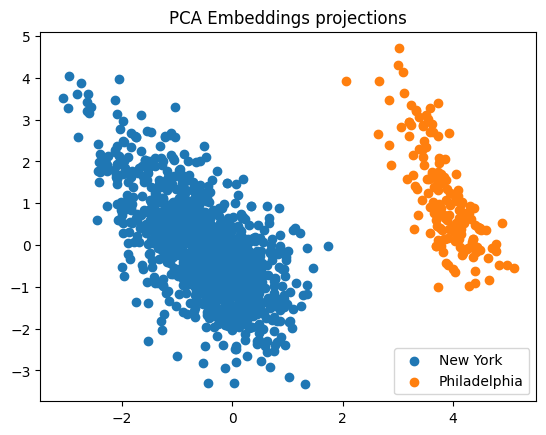

In [46]:
plt.scatter(X_pca[:len(embeddings1),0], X_pca[:len(embeddings1),1], label=TERM1)
plt.scatter(X_pca[len(embeddings1):,0], X_pca[len(embeddings1):,1], label=TERM2)
plt.legend()
plt.title("PCA Embeddings projections")

## Plot UMAP

In [47]:
import umap
# TODO: make plot interactive with context as text
mapper = umap.UMAP().fit(all_embeddings)

In [57]:

hover_data = pd.DataFrame()
hover_data['doc'] = [
    sentence.coha_doc._path.name
    for sentence in term1_sentences + term2_sentences
]
hover_data['text'] = [
    sentence.text
    for sentence in term1_sentences + term2_sentences
]

hover_data


,doc,text
0,news_1953_715250.txt,House Republican leaders are backing Represent...
1,fic_1979_10650.txt,"Employed by a clothing manufacturer , they wer..."
2,fic_1979_10650.txt,"At the pool , they socialized with wizards of ..."
3,fic_1979_10650.txt,"Far removed , to New York and New England @ @ ..."
4,fic_1979_10650.txt,"He looked like a New York actor , "" she laughe..."
...,...,...
1313,mag_1922_467450.txt,"logue of a nursery near Philadelphia , and we ..."
1314,news_1894_673550.txt,The fact was admitted to-day by several member...
1315,mag_1944_157650.txt,<P> ARTHUR GOLDMAN Philadelphia <P> Sirs : .
1316,mag_1987_336550.txt,<P> About 28% of the National Football League ...


In [58]:
import umap.plot

umap.plot.output_notebook()

labels = np.array(len(embeddings1) * [TERM1] + len(embeddings2) * [TERM2], dtype=str)
p = umap.plot.interactive(mapper, labels = labels, hover_data=hover_data)
#ax.set_title("UMAP Embeddings Projections")
umap.plot.show(p)


Loading BokehJS ...